In [1]:
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [2]:
import numpy as np
import matplotlib.pylab as plt
plt.rc('font', family='sans-serif')

from tqdm import tqdm

import torch
import torch.distributions as dist
import h5py

from geobed import BED_discrete
import geobed.fwd_collection.raytracer as raytracer

/home/dstrutz/sshfs/Libs/GeoBED/geobed/core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
filename_core = 'marmousi_vp_centersection'
filename = f"data/{filename_core}.npz"

with np.load(filename, allow_pickle=True) as marmousi_centersection:    
    x = marmousi_centersection['x']
    z = marmousi_centersection['z']
    marmousi_vp = marmousi_centersection['data']
    
# area of interest
e_x_min, e_x_max = min(x), max(x)
e_z_min, e_z_max = min(z), max(z)

dx, dz = x[1] - x[0], z[1] - z[0]

print(e_x_min, e_x_max)

3000.3185954411765 16500.503183088236



Entropy of prior:  15.043950080871582
Entropy of horizontal coordinate:  8.326693534851074
Entropy of vertical coordinate:   6.71725606918335


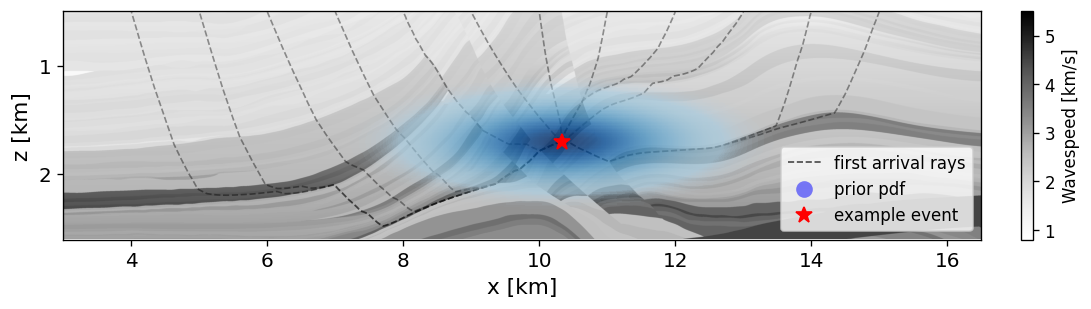

In [19]:
def construct_covmat(theta, ratio, scaling): 
    theta = -np.radians(theta)
    ratio = ratio
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    S = scaling * np.diag([ratio, 1])
    L = S**2
    return torch.tensor(R@L@R.T, dtype=dtype)

n_prior = int(1e6)
n_prior_plot = int(1e4)

# using float 32 for eveything to keep storage and loading times down
dtype = torch.float32

mu1=torch.tensor([10.33, 1.7])*1e3
cov1 = construct_covmat(0, 5, 0.2*1e3)

prior_dist = dist.MultivariateNormal(mu1, cov1)

prior_vert_dist = dist.Independent(dist.Normal(mu1[1:], torch.sqrt(cov1[1:,1:])), 1)
prior_hor_dist = dist.Independent(dist.Normal(mu1[:1], torch.sqrt(cov1[:1,:1])), 1)

print()
print('Entropy of prior: ', prior_dist.entropy().item())
print('Entropy of horizontal coordinate: ', prior_hor_dist.entropy().item())
print('Entropy of vertical coordinate:  ', prior_vert_dist.entropy().item())


n_prior = int(2e7)
n_prior_plot = int(1e4)

fig_x = (e_x_max-e_x_min)*1*0.8*1e-3
fig_z = (e_z_max-e_z_min)*1.5*0.8*1e-3

fig = plt.figure(figsize=(
                    fig_x,
                    fig_z), dpi=120)

ax_dict = fig.subplot_mosaic(
    '''aa
       aa''',
       gridspec_kw={'height_ratios': [1, 3], 'hspace': 0.05, 'width_ratios': [0.915, 0.085], 'wspace': 0.0},
       empty_sentinel='x', sharex=True)

tt_H = raytracer.TTHelper()
tt_H.set_model( x= x,  y= np.array([0]),  z=z,
               dx=dx, dy=           1.0, dz=dz,
               velocity_model=marmousi_vp)

receivers = np.array([4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]) *1e3

X, Z = np.meshgrid(x[::10], z[::10])
X, Z = X.flatten(), Z.flatten() 
XZ = np.column_stack([X, Z])

ax = tt_H.plot_model(
    vmin=800, vmax=5500,
    # prior_realisations=prior_dist.sample([n_prior_plot]).numpy(),
    pdf_dict={'x': x[::10], 'z': z[::10], 'pdf': torch.exp(prior_dist.log_prob(torch.tensor(XZ)).reshape(len(z[::10]), len(x[::10]))).numpy(),
              'cmap':'Blues', 'alpha_max': 0.8,},
    colorbar=True,
    # wells=mu_list,
    im_cmap='Greys',
    plot_rays=(mu1[0], mu1[1]), 
    receivers=np.vstack( [receivers, 0.5*1e3*np.ones((len(receivers)))] ).T,
    receiver_alpha=0.0,
    ax=ax_dict['a'],)

ax.plot([], [], 'ob', label='prior pdf', alpha=0.5, markeredgecolor='none', markersize=10)
ax.plot([mu1[0]/1e3,], [mu1[1]/1e3,], '*r', label='example event', markersize=10, zorder=10)

ax_dict['a'].legend(loc='lower right')

fig.savefig(f'figures/setup_interrogation.pdf', bbox_inches='tight', dpi=120)
fig.savefig(f'figures/setup_interrogation.png', bbox_inches='tight', dpi=120)

plt.show()


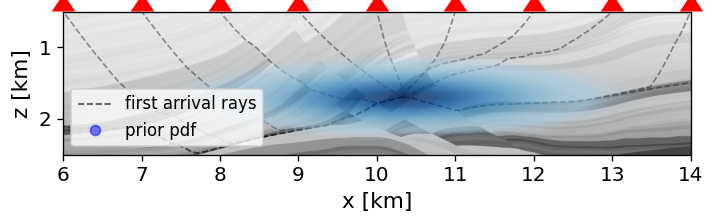

In [5]:
fig = plt.figure(figsize=(
                    fig_x,
                    fig_z*3/4), dpi=120)

ax_dict = fig.subplot_mosaic(
    '''aa
       aa''',
       gridspec_kw={'height_ratios': [1, 3], 'hspace': 0.05, 'width_ratios': [0.915, 0.085], 'wspace': 0.0},
       empty_sentinel='x', sharex=True)

tt_H = raytracer.TTHelper()
tt_H.set_model( x= x,  y= np.array([0]),  z=z,
               dx=dx, dy=           1.0, dz=dz,
               velocity_model=marmousi_vp)

receivers = np.array([4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]) *1e3

X, Z = np.meshgrid(x[::10], z[::10])
X, Z = X.flatten(), Z.flatten() 
XZ = np.column_stack([X, Z])

ax = tt_H.plot_model(
    vmin=800, vmax=5500,
    # prior_realisations=prior_dist.sample([n_prior_plot]).numpy(),
    pdf_dict={'x': x[::10], 'z': z[::10], 'pdf': torch.exp(prior_dist.log_prob(torch.tensor(XZ)).reshape(len(z[::10]), len(x[::10]))).numpy(),
              'cmap':'Blues', 'alpha_max': 0.8},
    colorbar=False,
    # wells=mu_list,
    im_cmap='Greys',
    plot_rays=(mu1[0], mu1[1]), 
    receivers=np.vstack( [receivers, 0.5*1e3*np.ones((len(receivers)))] ).T,
    ax=ax_dict['a'],)

ax.plot([], [], 'ob', label='prior pdf', alpha=0.5)

ax_dict['a'].set_xlim(6, 14)
ax_dict['a'].set_ylim(0.51, 2.5)
ax_dict['a'].invert_yaxis()

ax_dict['a'].legend(loc='lower left')

fig.savefig(f'figures/setup_interrogation_smaller.pdf', bbox_inches='tight', dpi=120)
fig.savefig(f'figures/setup_interrogation_smaller.png', bbox_inches='tight', dpi=120)

plt.show()

In [6]:
n_designs = int(100)

prior_samples = prior_dist.sample( (n_prior,) ).numpy()

designs = torch.ones((n_designs, 2))
designs[: ,0] = torch.linspace(3.1, 16.4, n_designs)*1e3
designs[: ,1] = 0.51 * torch.ones_like(designs[: ,0])*1e3

In [7]:
import os.path
from mpire import WorkerPool as Pool

filename_core = 'marmousi_gaussian_prior_traveltime'
filename = f"data/{filename_core}_{n_prior}_{n_designs}.h5"

print(prior_samples.shape)

n_parallel = 50

if os.path.isfile(filename):
    with h5py.File(filename, 'r') as f:
        # tt_array = f['data'][:]
        prior_samples = f['prior'][:]
    
    # tt_array = torch.from_numpy(tt_array)
    prior_samples = torch.from_numpy(prior_samples)

else:    
    def parallel_func(des):
        # be careful: prior samples is set at first definition of function
        return tt_H.calculate_tt_diff(des, prior_samples)
    
    tt_array = []
    print('starting parallel processing')
    with Pool(n_parallel) as pool:
        out = pool.map(parallel_func, [[des,] for des in designs], progress_bar=True, concatenate_numpy_output=False)
        tt_array = np.array(out).T
        
    mask = ~np.isnan(tt_array).any(axis=1)
    tt_array      = tt_array[mask]
    prior_samples = prior_samples[mask]
    
    tt_array = tt_array[:, :, None]
    
    with h5py.File(filename, 'w') as f:
        f.create_dataset("data",  data=tt_array)
        f.create_dataset("prior", data=prior_samples)     
    
    print('dimensions: (n_prior, n_design, data_dim)')
    print(tt_array.shape, tt_array.dtype,  '\n')

    # quick check if all calculations succeded and the data is ok
    print(np.count_nonzero(tt_array))
    print(np.count_nonzero(np.isnan(tt_array)))
    
    tt_array = torch.from_numpy(tt_array)
    prior_samples = torch.from_numpy(prior_samples)


(20000000, 2)


In [8]:
n_design_points = n_designs
design_names = [str(i) for i in range(n_design_points)]

design_dicts = {}

for i, name in enumerate(design_names):
    design_dicts[name] = {'index': i, 'x': designs[i, 0], 'z': designs[i, 1], 'file': filename, 'dataset': 'data', 'cost': 1.0}

In [9]:
std_model = 0.02
def data_likelihood(data, **kwargs):
    return dist.Independent(dist.Normal(data, std_model), 1)

In [10]:
BED_class = BED_discrete(design_dicts, data_likelihood,
                         prior_samples=prior_samples, prior_dist=prior_dist,
                         design2data='lookup_1to1_fast')

In [11]:
n_visual = int(1e4)

clean_data = BED_class.get_forward_samples(design_names, n_samples=n_visual)
noisy_data = BED_class.get_likelihood_samples(design_names, n_samples=n_visual)

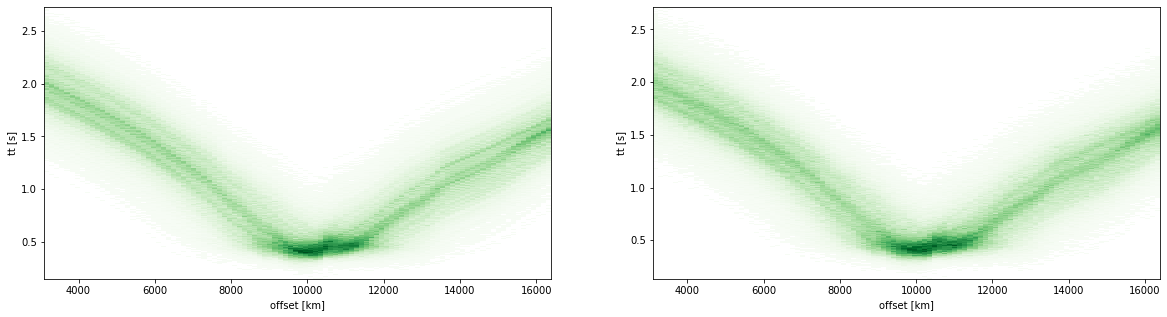

In [12]:
fig = plt.figure(figsize=(20, 5))
ax_dict = fig.subplot_mosaic('''ab''')

ax_dict['a'].hist2d(designs[:, 0].expand(n_visual, -1).flatten().numpy(),
                    clean_data.flatten().numpy(),
                    bins=[n_designs, 400], cmap='Greens', cmin=1)

ax_dict['b'].hist2d(designs[:, 0].expand(n_visual, -1).flatten().numpy(),
                    noisy_data.flatten().numpy(),
                    bins=[n_designs, 400], cmap='Greens', cmin=1)
    
ax_dict['a'].set_ylabel('tt [s]')
ax_dict['b'].set_ylabel('tt [s]')

ax_dict['a'].set_xlabel('offset [km]')
ax_dict['b'].set_xlabel('offset [km]')


# fig.savefig(f'../figures/datadist_gmm_prior.pdf', bbox_inches='tight', dpi=150)
# fig.savefig(f'../figures/datadist_gmm_prior.png', bbox_inches='tight', dpi=150)
                        
plt.show()

In [13]:
design_budget = 2
n_parallel = 50

In [14]:
from geobed.guides import MDN_guide

In [15]:
optimal_design_dict = {}
info_dict = {}

In [16]:
method = 'int_full_location'

N = int(5e4 )
M = int(5e4 )
n_batch = 50
n_epochs = 50

scheduler = torch.optim.lr_scheduler.StepLR

optimal_design_dict[method], info_dict[method] = BED_class.find_optimal_design(
    design_point_names=design_names,
    design_budget=design_budget,
    eig_method='variational_posterior',
    eig_method_kwargs=
    {'guide': MDN_guide,
     'N': N,
     'M': M,
     'guide_kwargs': {'components':30, 'hidden_features':[60, 60, 60], 'normalize':True},
     'n_batch': n_batch,
     'n_epochs': n_epochs,
    #  'optimizer': torch.optim.Adam,
     'optimizer_kwargs': {'lr': 1e-4},
     'scheduler': scheduler,
     'scheduler_kwargs': {'step_size':n_epochs//4, 'gamma':0.3},
     'return_guide': True,
     'return_train_loss': True,
     'return_test_loss': True,
     },
    opt_method='iterative_construction',
    opt_method_kwargs={},
    num_workers=n_parallel,
    filename='data/srcloc_bed_{}.pkl'.format(method),
    )

ModuleNotFoundError: No module named 'guides'

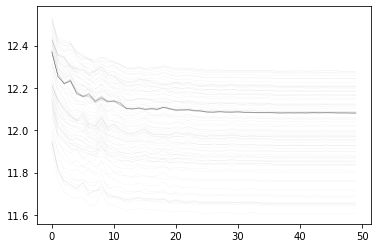

In [ ]:
for i in range(n_designs):
    plt.plot((info_dict['int_full_location'][2]['info'][i]['test_loss']), color='k', alpha=0.2, linewidth=0.1)
plt.show()

In [ ]:
def depth_only(model_space):
    # return only the z-coordinate of the source location
    return model_space[:, [1]] # index in brackets to preserve shape 

In [ ]:
method = 'int_depth'

N = int(5e4)
M = int(5e4)
n_batch = 50
n_epochs = 50

scheduler = torch.optim.lr_scheduler.StepLR

optimal_design_dict[method], info_dict[method] = BED_class.find_optimal_design(
    design_point_names=design_names,
    design_budget=design_budget,
    eig_method='variational_posterior',
    eig_method_kwargs=
    {'guide': MDN_guide,
     'N': N,
     'M': M,
     'guide_kwargs': {'components':30, 'hidden_features':[60, 60, 60], 'normalize':True},
     'n_batch': n_batch,
     'n_epochs': n_epochs,
    #  'optimizer': torch.optim.Adam,
     'optimizer_kwargs': {'lr': 1e-4},
     'scheduler': scheduler,
     'scheduler_kwargs': {'step_size':n_epochs//4, 'gamma':0.3},
     'interrogation_mapping': depth_only,
     'prior_entropy': prior_vert_dist.entropy().item(),
     'return_guide': True,
     'return_train_loss': True,
     'return_test_loss': True,
     },
    opt_method='iterative_construction',
    opt_method_kwargs={},
    num_workers=n_parallel,
    filename='data/srcloc_bed_{}.pkl'.format(method),
    )

Loading optimal design from data/srcloc_bed_int_depth.pkl


In [ ]:
def horizontal_only(model_space):
    # return only the z-coordinate of the source location
    return model_space[:, [0]] # index in brackets to preserve shape 

In [ ]:
method = 'int_horizontal'

N = int(5e4)
M = int(5e4)
n_batch = 50
n_epochs = 70

scheduler = torch.optim.lr_scheduler.StepLR

optimal_design_dict[method], info_dict[method] = BED_class.find_optimal_design(
    design_point_names=design_names,
    design_budget=design_budget,
    eig_method='variational_posterior',
    eig_method_kwargs=
    {'guide': MDN_guide,
     'N': N,
     'M': M,
     'guide_kwargs': {'components':30, 'hidden_features':[60, 60, 60], 'normalize':True},
     'n_batch': n_batch,
     'n_epochs': n_epochs,
    #  'optimizer': torch.optim.Adam,
     'optimizer_kwargs': {'lr': 1e-4},
     'scheduler': scheduler,
     'scheduler_kwargs': {'step_size':n_epochs//4, 'gamma':0.3},
     'interrogation_mapping': horizontal_only,
     'prior_entropy': prior_hor_dist.entropy().item(),
     'return_guide': True,
     'return_train_loss': True,
     'return_test_loss': True,
     },
    opt_method='iterative_construction',
    opt_method_kwargs={},
    num_workers=n_parallel,
    filename='data/srcloc_bed_{}.pkl'.format(method),
    )

Loading optimal design from data/srcloc_bed_int_horizontal.pkl


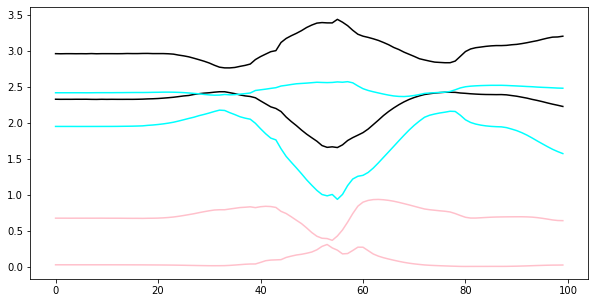

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for i in range(1, 2+1):
    ax.plot(info_dict['int_full_location'][i]['eig'], label='int_full_location', color='k')
    ax.plot(info_dict['int_depth'][i]['eig'], label='int_depth', color='pink')
    ax.plot(info_dict['int_horizontal'][i]['eig'], label='int_horizontal', color='cyan')

plt.show()

In [ ]:
import matplotlib.ticker as ticker

def plot_vis(receiver_i, int_problem, plot_rays, plot_rays_inv, guide, filename=None, true_location=True, true_i=1, EIG_offset=0, ylim=None, ax_dict=None):
    
    torch.manual_seed(0)
        
    if type(receiver_i) == int:
        receiver_i = [str(receiver_i),]
        
    noisy_data = BED_class.get_likelihood_samples(receiver_i, n_samples=true_i+1)[[true_i,]]

    true_loc = BED_class.prior_samples[true_i]

    if ax_dict is None:
        fig, ax_dict = plt.subplot_mosaic('''a
                                            b''', figsize=(10, 6),
                                            gridspec_kw={'height_ratios': [2, 4]},
        )
    else:
        fig = plt.gcf()

    fig.patch.set_facecolor('None')
    for ax in ax_dict.values():
        ax.patch.set_facecolor('None')
    
    for spine in ['top', 'bottom', 'right']:
        ax_dict['a'].spines[spine].set_visible(False)
    ax_dict['a'].set_xticks([])

    ax_dict['a'].set_ylabel('EIG', fontsize=13)
    ax = ax_dict['b']

    tt_H = raytracer.TTHelper()
    tt_H.set_model( x= x,  y= np.array([0]),  z=z,
                dx=dx, dy=           1.0, dz=dz,
                velocity_model=marmousi_vp)

    sampling_grid = 10

    X, Z = np.meshgrid(x[::sampling_grid], z[::sampling_grid])
    X, Z = X.flatten(), Z.flatten()

    XZ = np.column_stack([X, Z])
    
    posterior_prob = torch.exp(guide.log_prob(torch.tensor(XZ).float(), noisy_data).reshape(len(z[::sampling_grid]), len(x[::sampling_grid]))).detach().numpy()

    if not (plot_rays or plot_rays_inv):
        ax = tt_H.plot_model(
            vmin=800, vmax=5500,
            # prior_realisations=prior_dist.sample([n_prior_plot]).numpy(),
            pdf_dict={'x': x[::10], 'z': z[::10], 'pdf': posterior_prob,
                    'cmap':'Reds', 'alpha_max': 0.8},
            colorbar=False,
            # wells=mu_list,
            im_cmap='Greys',
            # plot_rays=(true_loc[0], true_loc[1]),
            # receivers=designs[::10],
            ax=ax,)
    if plot_rays:
        ax = tt_H.plot_model(
            vmin=800, vmax=5500,
            # prior_realisations=prior_dist.sample([n_prior_plot]).numpy(),
            pdf_dict={'x': x[::10], 'z': z[::10], 'pdf': posterior_prob,
                    'cmap':'Reds', 'alpha_max': 0.8},
            colorbar=False,
            # wells=mu_list,
            im_cmap='Greys',
            plot_rays=(true_loc[0], true_loc[1]),
            receivers=designs[::10],
            ax=ax,)
    if plot_rays_inv:
        g_samples = guide.sample(noisy_data, n_samples=20).detach().numpy()[:, 0, :]
        ax = tt_H.plot_model(
            vmin=800, vmax=5500,
            # prior_realisations=prior_dist.sample([n_prior_plot]).numpy(),
            pdf_dict={'x': x[::10], 'z': z[::10], 'pdf': posterior_prob,
                    'cmap':'Reds', 'alpha_max': 0.8},
            colorbar=False,
            # wells=mu_list,
            im_cmap='Greys',
            plot_rays=(designs[receiver_i][0], designs[receiver_i][1]),
            receivers=g_samples,
            ax=ax,)

    ax.plot([], [], 'or', markeredgewidth=0, label='posterior pdf', alpha=0.5)

    ax.scatter(designs[list(map(int, receiver_i)), 0]/1e3, designs[list(map(int, receiver_i)), 1]/1e3, color='r',
            marker=10, clip_on=False, s=400)

    ax.scatter([], [], color='r', marker='^', label='receivers')

    if true_location:   
        true_location = BED_class.prior_samples[[true_i,]]        
        ax.scatter(true_location[:, 0]/1e3, true_location[:, 1]/1e3, color='k', label='true location',
                   marker='x', s=70, zorder=10, linewidths=2.5)

    ax.set_xlim(5.33, 15.33)
    ax.set_ylim(0.51, 2.5)
    ax.invert_yaxis()

    # ax.legend(loc='lower right')

    ax_dict['a'].plot(designs[: ,0]/1e3, 
                        info_dict[int_problem][len(receiver_i)]['eig']+EIG_offset,
                        label='EIG', color='k', linewidth=2)
    ax_dict['a'].set_xlim(5.33, 15.33)
    
    if ylim is None:
        ylim = ax_dict['a'].get_ylim()

        ax_dict['a'].set_ylim(ylim[0]-0.2, ylim[1]+0.2)
        # ax_dict['a'].yaxis.set_major_locator(ticker.MultipleLocator(0.2))
    else:
        ax_dict['a'].set_ylim(ylim[0], ylim[1])
        
    ax_dict['a'].yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

    if filename is not None:
        fig.savefig(f'{filename}.png'
                    , bbox_inches='tight', dpi=120, transparent=True)
        fig.savefig(f'{filename}.pdf',
                    bbox_inches='tight', dpi=120,transparent=True)

    if ax_dict is None:
        plt.gcf().set_dpi(120)
        plt.show()

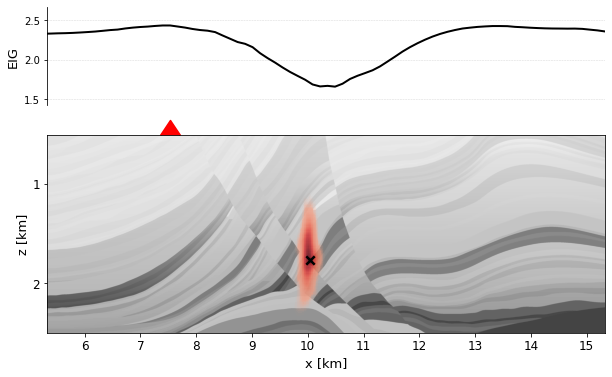

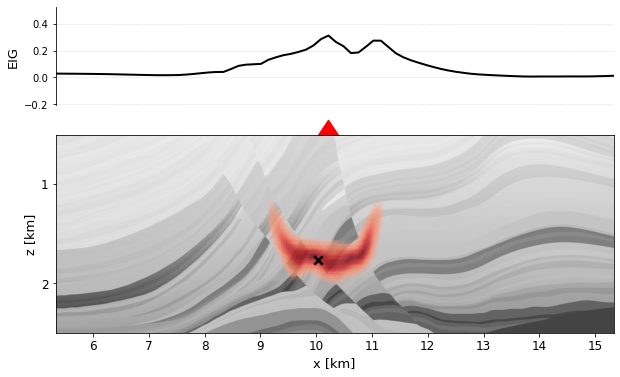

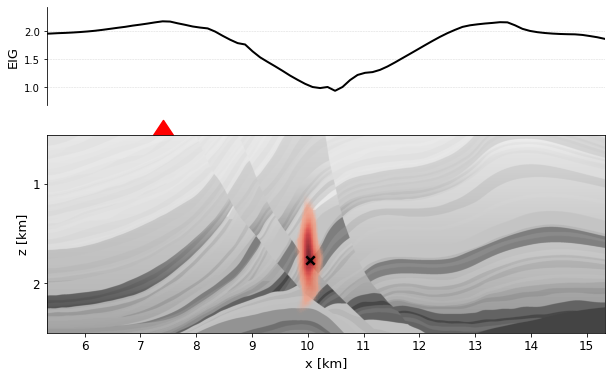

In [ ]:
for int_problem in ['int_full_location', 'int_depth', 'int_horizontal']:

    plot_vis(
    int(optimal_design_dict[int_problem][0]), int_problem = int_problem,
    guide=info_dict['int_full_location'][1]['info'][int(optimal_design_dict[int_problem][0])]['guide'],
    plot_rays=False, plot_rays_inv=False,
    # filename='figures/visualisations/introduction_good_example'
    )

In [ ]:
print(optimal_design_dict)

{'int_full_location': ['33', '55'], 'int_depth': ['53', '63'], 'int_horizontal': ['32', '57']}


In [ ]:
plotting_optimal_designs = [[str(x) for x in od] for od in optimal_design_dict.values()]

plotting_optimal_designs = [sorted(item, key=float) for item in plotting_optimal_designs]

plotting_eig, plotting_info_dict= BED_class.calculate_eig_list(
    design_list=plotting_optimal_designs,
    method='variational_posterior',
    method_kwargs=
    {'guide': MDN_guide,
     'N': N,
     'M': M,
     'guide_kwargs': {'components':30, 'hidden_features':[60, 60, 60], 'normalize':True},
     'n_batch': n_batch,
     'n_epochs': n_epochs,
    #  'optimizer': torch.optim.Adam,
     'optimizer_kwargs': {'lr': 1e-3},
     'scheduler': scheduler,
     'scheduler_kwargs': {'step_size':n_epochs//6, 'gamma':0.3},
     'return_guide': True,
     'return_train_loss': True,
     'return_test_loss': True,
     },
    num_workers=3,
    filename='data/plotting_optimal_designs.pkl'.format(method),
    )

Loading eig values from data/plotting_optimal_designs.pkl


[33, 55]
[53, 63]
[32, 57]


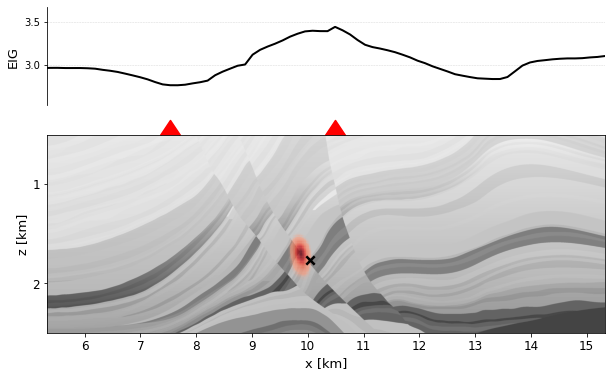

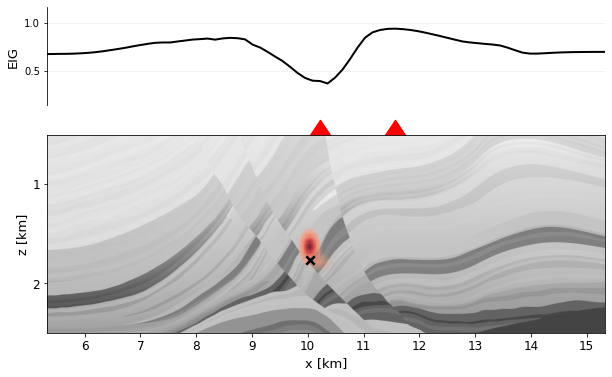

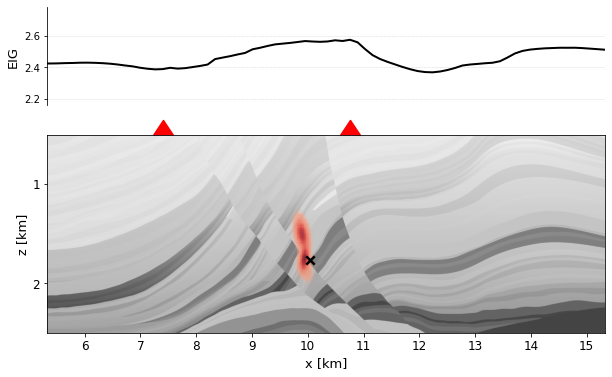

In [ ]:
for i, int_problem in enumerate(['int_full_location', 'int_depth', 'int_horizontal']):

    print( list(map(int, optimal_design_dict[int_problem][:2])))

    plot_vis(
    optimal_design_dict[int_problem][:2], int_problem = int_problem,
    guide = plotting_info_dict[i]['guide'],
    plot_rays=False, plot_rays_inv=False,
    # filename='figures/visualisations/introduction_good_example'
    )

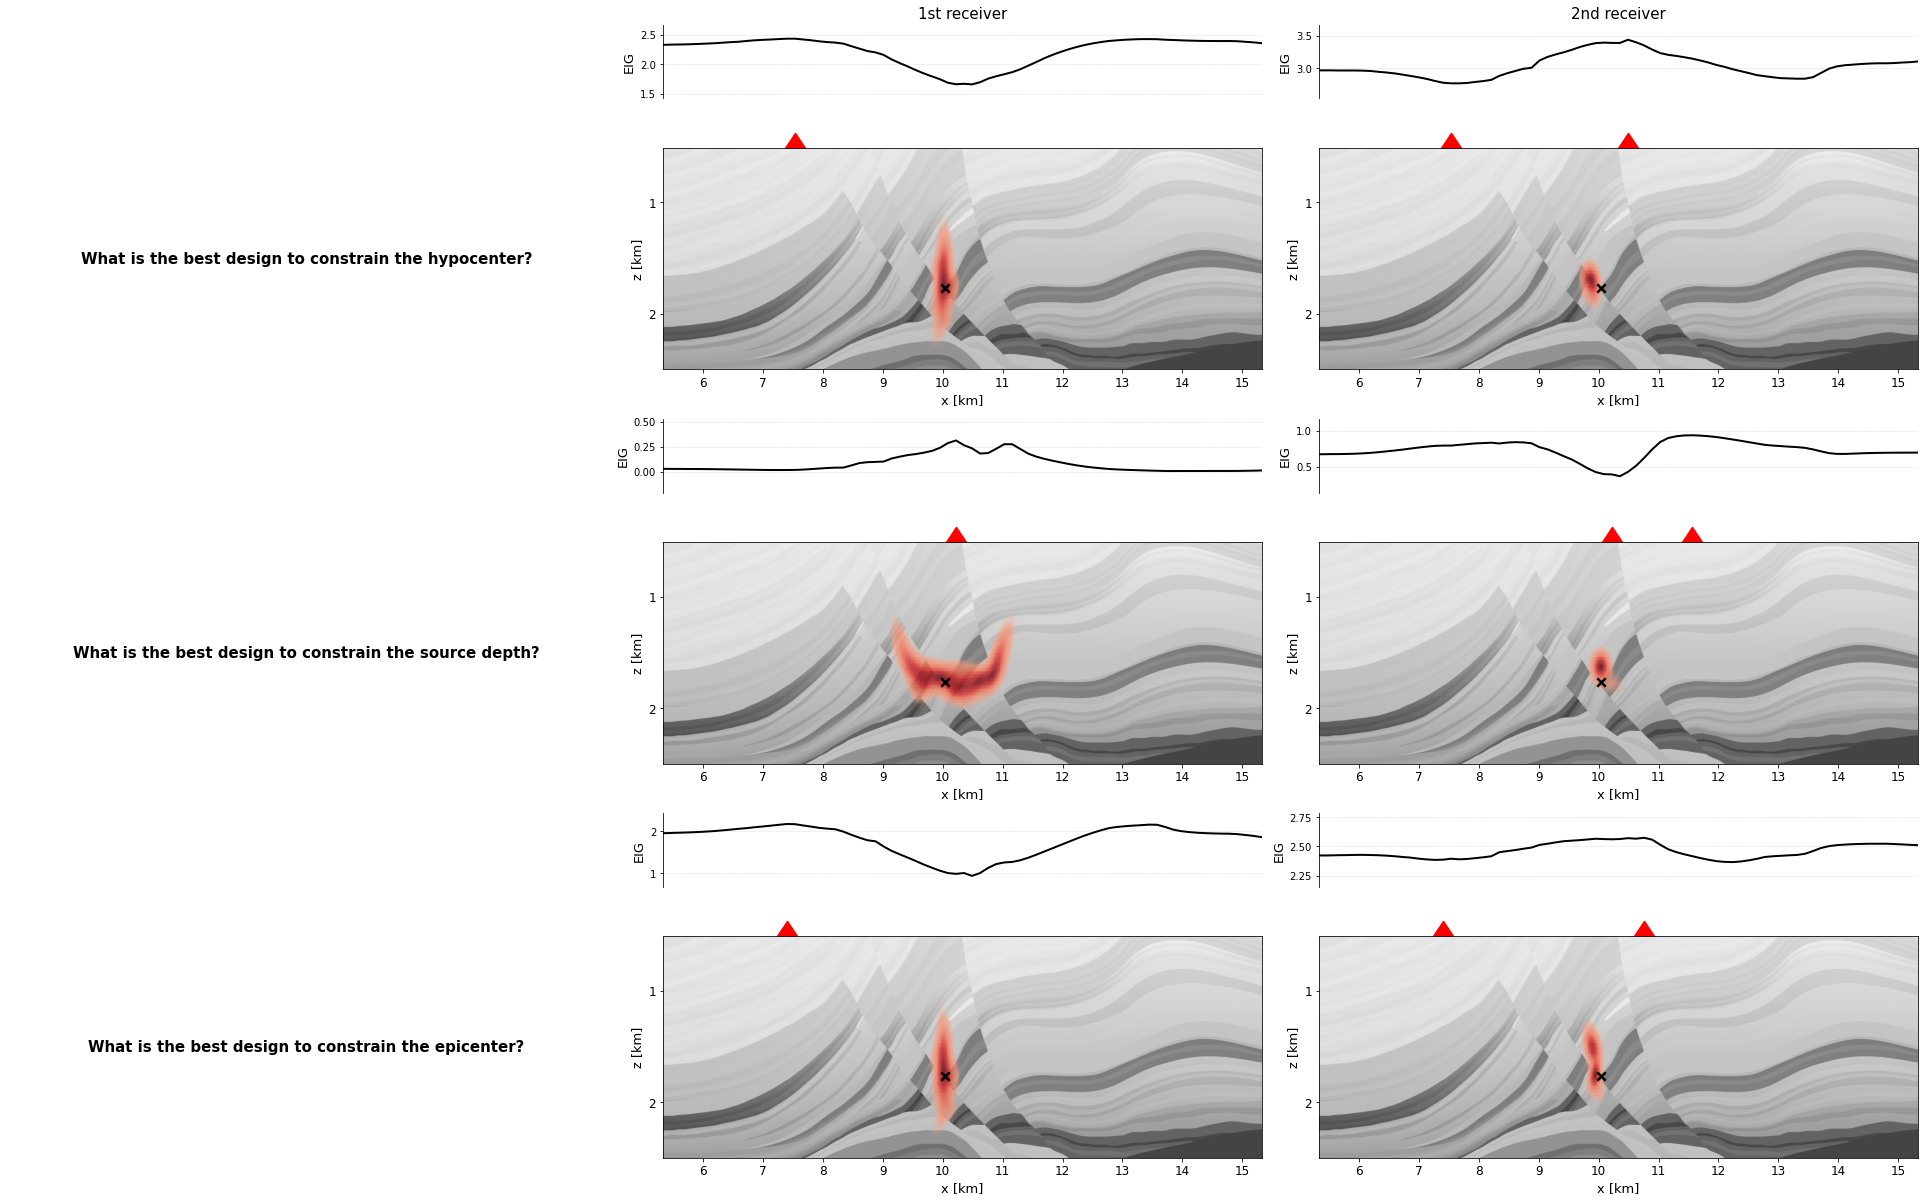

In [ ]:
fig, ax_dict = plt.subplot_mosaic([['111', '121', '131'],
                                   ['112', '122', '132'],
                                   ['211', '221', '231'],
                                   ['212', '222', '232'],
                                   ['311', '321', '331'],
                                   ['312', '322', '332']],
                                   figsize=(fig_x*2, fig_z*4/3*3),
                                   gridspec_kw={'height_ratios': [1, 3, 1, 3, 1, 3]},
)

for i, int_problem in enumerate(['int_full_location', 'int_depth', 'int_horizontal']):
    
    for i_rec in range(2):

        upper_ax = ax_dict[f'{i+1}{i_rec+2}1']
        ax = ax_dict[f'{i+1}{i_rec+2}2']
        
        if i_rec == 0:
            plot_vis(
                int(optimal_design_dict[int_problem][0]), int_problem = int_problem,
                guide=info_dict['int_full_location'][1]['info'][int(optimal_design_dict[int_problem][0])]['guide'],
                plot_rays=False, plot_rays_inv=False,
                ax_dict={'a':upper_ax, 'b':ax}
                )
        else:
            plot_vis(
                optimal_design_dict[int_problem][:2], int_problem = int_problem,
                guide = plotting_info_dict[i]['guide'],
                plot_rays=False, plot_rays_inv=False,
                ax_dict={'a':upper_ax, 'b':ax}
                )
        
for i, int_problem in enumerate(['int_full_location', 'int_depth', 'int_horizontal']):
    ax = ax_dict[f'{i+1}12']
    
    if int_problem == 'int_full_location':
        ax.text(0.5, 0.5, 'What is the best design to constrain the hypocenter?',
                transform=ax.transAxes, fontsize=15, fontweight='bold', va='center', ha='center')
    if int_problem == 'int_depth':
        ax.text(0.5, 0.5, 'What is the best design to constrain the source depth?',
                transform=ax.transAxes, fontsize=15, fontweight='bold', va='center', ha='center')
    if int_problem == 'int_horizontal':
        ax.text(0.5, 0.5, 'What is the best design to constrain the epicenter?', transform=ax.transAxes,
                fontsize=15, fontweight='bold', va='center', ha='center')

    for spine in ['top', 'bottom', 'left', 'right']:
        ax_dict[f'{i+1}11'].spines[spine].set_visible(False)
        ax_dict[f'{i+1}12'].spines[spine].set_visible(False)
        
        ax_dict[f'{i+1}11'].set_xticks([])
        ax_dict[f'{i+1}11'].set_yticks([])
        
        ax_dict[f'{i+1}12'].set_xticks([])
        ax_dict[f'{i+1}12'].set_yticks([])

    if i == 0:
        ax_dict[f'{i+1}21'].set_title('1st receiver', fontsize=15)
        ax_dict[f'{i+1}31'].set_title('2nd receiver', fontsize=15)
    
fig.savefig(f'figures/interrogation_summary_2rec.pdf', bbox_inches='tight', dpi=120, transparent=True)
fig.savefig(f'figures/interrogation_summary_2rec.png', bbox_inches='tight', dpi=120, transparent=True)

plt.tight_layout()    
plt.show()

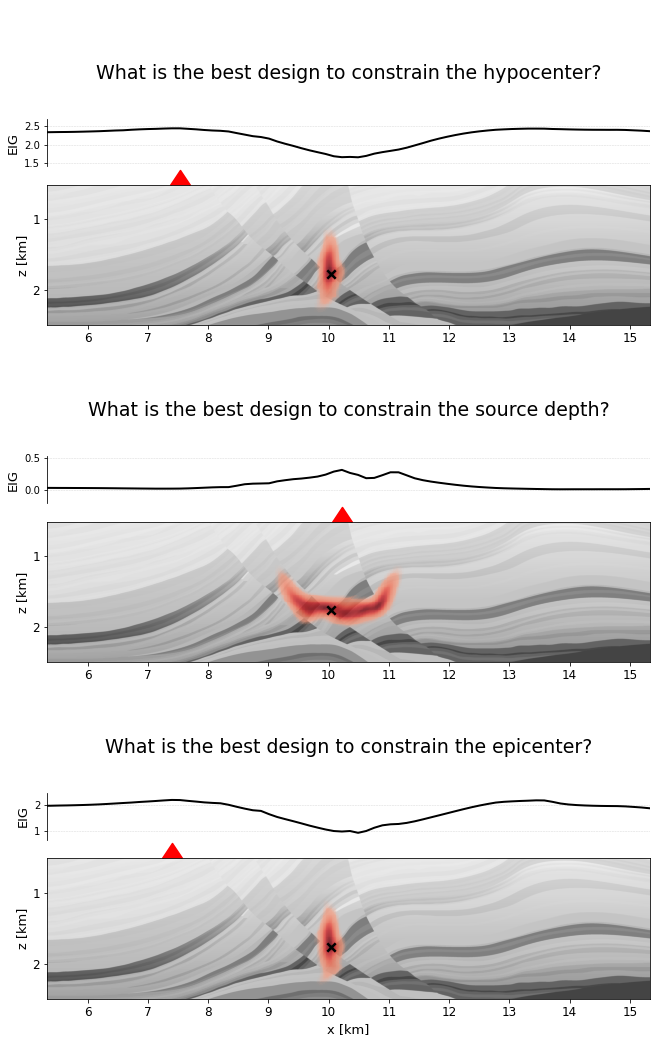

In [ ]:
fig, ax_dict = plt.subplot_mosaic([['121'],
                                   ['122'],
                                   ['123'],
                                   ['221'],
                                   ['222'],
                                   ['223'],
                                   ['321'],
                                   ['322'],
                                   ['323'],],
                                   figsize=(fig_x*0.8, fig_z*4/3*2.4+4.8),
                                   gridspec_kw={'height_ratios': [2, 1, 3, 2, 1, 3, 2, 1, 3],
                                                # 'hspace': 0.0,
                                                })

for i, int_problem in enumerate(['int_full_location', 'int_depth', 'int_horizontal']):
    
    for i_rec in range(1):
        
        upper_ax = ax_dict[f'{i+1}{i_rec+2}2']
        ax = ax_dict[f'{i+1}{i_rec+2}3']
        
        plot_vis(
            int(optimal_design_dict[int_problem][0]), int_problem = int_problem,
            guide=info_dict['int_full_location'][1]['info'][int(optimal_design_dict[int_problem][0])]['guide'],
            plot_rays=False, plot_rays_inv=False,
            ax_dict={'a':upper_ax, 'b':ax}
            )

for i, int_problem in enumerate(['int_full_location', 'int_depth', 'int_horizontal']):
    
    ax = ax_dict[f'{i+1}21']
    
    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = ax_dict[f'{i+1}22']

    if int_problem == 'int_full_location':
        ax.set_title('What is the best design to constrain the hypocenter?', fontsize=19, pad=40)
    if int_problem == 'int_depth':
        ax.set_title('What is the best design to constrain the source depth?', fontsize=19, pad=40)
    if int_problem == 'int_horizontal':
        ax.set_title('What is the best design to constrain the epicenter?', fontsize=19, pad=40)

    # ax_dict[f'{i+1}21'].set_title('1st receiver')
    
fig.savefig(f'figures/interrogation_summary_1rec.pdf', bbox_inches='tight', dpi=120, transparent=True)
fig.savefig(f'figures/interrogation_summary_1rec.png', bbox_inches='tight', dpi=120, transparent=True)

# plt.tight_layout()    
plt.show()